<a href="https://colab.research.google.com/github/pjprathmesh/Music-Generator/blob/master/Midi_v2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip
!unzip /content/maestro-v2.0.0-midi.zip

In [ ]:
!pip install pretty_midi

In [ ]:
import pretty_midi
import numpy as np
import os
from keras.layers import LSTM,Input,Dense,Dropout
from keras.models import Model
from keras.callbacks import LambdaCallback
from keras.utils   import to_categorical
def create():
    max_T_x = 1000
    l1=os.listdir("/content/maestro-v2.0.0")
    l2=[i for i in l1 if i.isnumeric() ]
    l3=[os.listdir(os.path.join("/content/maestro-v2.0.0",j)) for j in l2]

    mapp=[i for i in range(109)]
    char2vec={e:i for e,i in enumerate(mapp)}
    vec2char={i:e for e,i in enumerate(mapp)}

    ma=0
    final=np.zeros((9900,20,110))
    pre=np.zeros((9900,20,110))
    for e,i in enumerate(l3):
        if e==1:
            break

        for h,j in enumerate(i):
            if h==10:
              break
              
            midi_pretty_format = pretty_midi.PrettyMIDI(os.path.join("/content/maestro-v2.0.0",l2[e],j))
            note_l = [note.pitch for note in midi_pretty_format.instruments[0].notes][:2000]
            for k in range(0,len(note_l)-20,3):
                final_vt=note_l[k:k+20]
                pred=final_vt.copy()
                del final_vt[-1]
                final_vt=[0]+final_vt

                try:
                    final_v=to_categorical(final_vt,110)
                    pre[ma]=to_categorical(pred,110)
                    final[ma]=final_v
                except:
                    pass
                ma+=1
                print(ma)
            
    yield final,pre
      
    print("done")
aio=list(create())

In [6]:
aio[0][0].shape,aio[0][1].shape,

((25179, 20, 110), (25179, 20, 110))

In [24]:
xx=aio[0][0].copy()
yy=aio[0][1].copy()

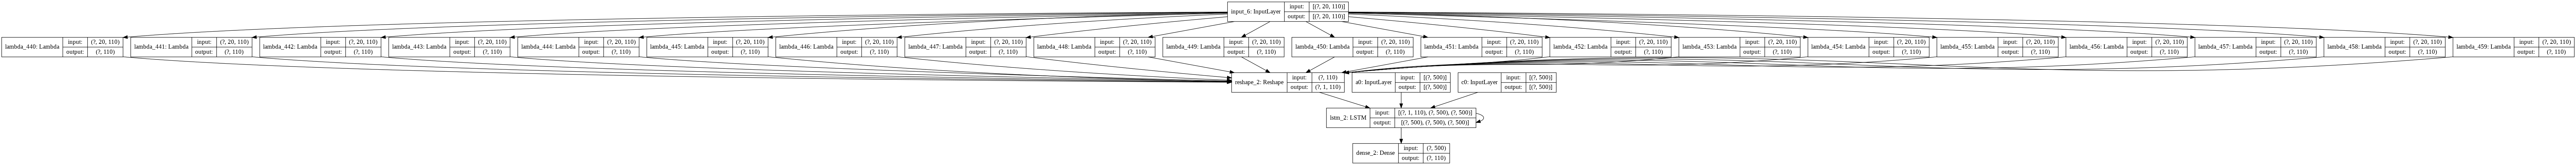

In [25]:
import keras
from keras.layers import Reshape,Lambda,Input
import tensorflow as tf
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

n_a=500
n_values=110
Tx=20
reshapor = Reshape((1, n_values))
LSTM_cell = LSTM(n_a, return_state = True)
densor = Dense(n_values, activation='softmax') 


X = Input(shape=(Tx, n_values))
a00 = Input(shape=(n_a,), name='a0')
c00 = Input(shape=(n_a,), name='c0')
a=a00
c=c00
outputs = []
    
for t in range(Tx):
        
        x = Lambda(lambda x: X[:,t,:])(X)
        x = reshapor(x)
        a, _, c = LSTM_cell(inputs=x, initial_state=[a, c])
        out = densor(a)
        outputs.append(out)
        
model = Model(inputs=[X, a00, c00], outputs=outputs)


from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [10]:
model.layers[0].output

<tf.Tensor 'input_1:0' shape=(None, 20, 110) dtype=float32>

In [26]:
from keras.optimizers import Adam

opt = Adam(lr=0.01)# beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
m = 9900
n_a=500
h_s = np.zeros((m, n_a))
c_s = np.zeros((m, n_a))
Y=np.transpose(yy,(1,0,2))
model.fit(x=[xx, h_s, c_s], y=list(Y), epochs=10)

Train on 9900 samples
Epoch 1/10
9900/9900 [==============================] - 15s 2ms/sample - loss: 68.4588 - dense_2_loss: 4.0335 - dense_2_1_loss: 3.7614 - dense_2_2_loss: 3.6197 - dense_2_3_loss: 3.5196 - dense_2_4_loss: 3.4398 - dense_2_5_loss: 3.3807 - dense_2_6_loss: 3.3628 - dense_2_7_loss: 3.3419 - dense_2_8_loss: 3.3281 - dense_2_9_loss: 3.3247 - dense_2_10_loss: 3.3184 - dense_2_11_loss: 3.3289 - dense_2_12_loss: 3.3250 - dense_2_13_loss: 3.3335 - dense_2_14_loss: 3.3234 - dense_2_15_loss: 3.3374 - dense_2_16_loss: 3.3340 - dense_2_17_loss: 3.3322 - dense_2_18_loss: 3.3449 - dense_2_19_loss: 3.3347 - dense_2_accuracy: 0.0362 - dense_2_1_accuracy: 0.0759 - dense_2_2_accuracy: 0.0999 - dense_2_3_accuracy: 0.1141 - dense_2_4_accuracy: 0.1275 - dense_2_5_accuracy: 0.1343 - dense_2_6_accuracy: 0.1422 - dense_2_7_accuracy: 0.1379 - dense_2_8_accuracy: 0.1468 - dense_2_9_accuracy: 0.1469 - dense_2_10_accuracy: 0.1470 - dense_2_11_accuracy: 0.1471 - dense_2_12_accuracy: 0.1451 - den

In [27]:
from keras.layers import RepeatVector
def one_hot(x):
  x = keras.backend.argmax(x)
  # x=tf.random.categorical(x,1,dtype=tf.int64)
  x = tf.one_hot(indices=x, depth=110)
  x = RepeatVector(1)(x)
  return x
x_test = Input(shape=(1, n_values))
a_test = Input(shape=(n_a,), name='a0')
c_test = Input(shape=(n_a,), name='c0')
at = a_test
ct = c_test
xt= x_test
Ty=80

outputs2 = []

for t in range(Ty):
    
    at, _, ct = LSTM_cell(inputs=xt, initial_state=[at, ct])
    
    out = densor(at)

    outputs2.append(out)
    

    xt = Lambda(lambda x: one_hot(x))(out)
    
inference_model = Model(inputs=[x_test,a_test,c_test],outputs=outputs2)

In [28]:
x_initializer = np.zeros((1, 1, 110))
a_initializer = np.zeros((1, n_a))
c_initializer = np.zeros((1, n_a))
pred = inference_model.predict([x_initializer, a_initializer, c_initializer])
indices = np.argmax(np.array(pred),axis=-1)
indices.ravel()

array([70, 58, 74, 54, 78, 58, 74, 42, 75, 59, 71, 54, 75, 59, 71, 81, 54,
       83, 59, 80, 54, 59, 83, 80, 42, 77, 59, 80, 54, 59, 77, 80, 54, 85,
       59, 81, 54, 77, 59, 85, 81, 42, 82, 58, 81, 54, 82, 58, 77, 54, 78,
       58, 77, 54, 78, 58, 72, 54, 73, 58, 72, 54, 73, 58, 69, 54, 70, 58,
       69, 70, 54, 58, 65, 54, 66, 58, 65, 54, 66, 58])

In [29]:
midi_pretty_format=pretty_midi.PrettyMIDI()
cello = pretty_midi.Instrument(program=2)
time = 0
step = 0.3
for note_number in indices.ravel():

    myNote = pretty_midi.Note(velocity=100, pitch=note_number, start=time, end=time+step)
    cello.notes.append(myNote)
    time += step
midi_pretty_format.instruments.append(cello)
midi_pretty_format.write('cell.midi')

import IPython
audio_data = midi_pretty_format.synthesize()
IPython.display.Audio(audio_data, rate=44100)